# Systematic testing of Bayesian unfolding using simulated spectra from LaBr3, Plastic, and PIPS detector 

Created by Andrei R. Hanu

In [3]:
# Libraries to handle ROOT files
import ROOT
import root_numpy

# Theano
import theano
import theano.tensor

# Copy function
import copy

# NumPy
import numpy as np

# PyMC3
import pymc3 as pm
print('PyMC3 version:', pm.__version__)

# The MCMC Hammer
import emcee
print('emcee version:', emcee.__version__)

# Texttable
from texttable import Texttable

# Color palette library for Python
# How to choose a colour scheme for your data:
# http://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/05/subtleties-of-color-part-1-of-6/
import palettable

# Matplotlib - 2D plotting library
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
#import seaborn.apionly as sns
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import Grid, AxesGrid

# Python garbabe collector
import gc

('PyMC3 version:', '3.4')
('emcee version:', '3.0.2')


In [4]:
##########################################################################################
# Setting rcParams for publication quality graphs
fig_size =  np.array([7.3,4.2])*1.5
params = {'backend': 'pdf',
        'axes.labelsize': 12,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'xtick.major.size': 7,
        'xtick.major.width': 1,
        'xtick.minor.size': 3.5,
        'xtick.minor.width': 1.25,
        'ytick.major.size': 7,
        'ytick.major.width': 1.25,
        'ytick.minor.size': 3.5,
        'ytick.minor.width': 1.25,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Bitstream Vera Sans',
        'font.size': 11,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [5]:
# Threshold Energy, in keV, above which unfolding will occur
thld_e = 10.

# Configuration
det1 = 'Saint Gobain B380 LaBr3'
det2 = 'Eljen Plastic Detector'
det3 = 'Canberra PD450-15-500AM'

# isotope = 'Cl36'
#isotope = 'Kr85'
isotope = 'Sr90Y90'
#isotope = 'Cs137'
#isotope = 'gamma_Power_10_10000_keV_alpha_-4_electron_Gauss_3000_100_keV'
# isotope = 'gamma_Power_10_10000_keV_alpha_-3_electron_Gauss_600_600_keV'
f_data = isotope + '_R_25_cm_Nr_100000000_ISO.root'

## STEP 1 - Import the detector response matrices

In [6]:
# Load the ROOT file containing the response matrix for the detector
f_rspns = ROOT.TFile.Open('./TestData/'+det1+'/Response Matrix/'+det1+'.root')

# Retrieve the electron and gamma-ray energy migration matrices and source vectors (i.e. the true spectrum from which the response matrix was simulated)
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
src_vec_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))

src_vec_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

mig_mat_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))
    
mig_mat_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

# Calculate the response matrices by normalizing the energy migration matrices by the source vectors
rspns_mat_det1_e = copy.deepcopy(mig_mat_e)
rspns_mat_det1_e[0] = np.nan_to_num(rspns_mat_det1_e[0]/src_vec_e[0])
rspns_mat_det1_gam = copy.deepcopy(mig_mat_gam)
rspns_mat_det1_gam[0] = np.nan_to_num(rspns_mat_det1_gam[0]/src_vec_e[0])

# Remove response matrix elements below threshold energy
rspns_mat_det1_e[0] = np.delete(rspns_mat_det1_e[0], np.where(rspns_mat_det1_e[1][0] < thld_e), axis=0)
rspns_mat_det1_e[0] = np.delete(rspns_mat_det1_e[0], np.where(rspns_mat_det1_e[1][0] < thld_e), axis=1)
rspns_mat_det1_e[1] = np.delete(rspns_mat_det1_e[1], np.where(rspns_mat_det1_e[1][0] < thld_e), axis=1)
rspns_mat_det1_gam[0] = np.delete(rspns_mat_det1_gam[0], np.where(rspns_mat_det1_gam[1][0] < thld_e), axis=0)
rspns_mat_det1_gam[0] = np.delete(rspns_mat_det1_gam[0], np.where(rspns_mat_det1_gam[1][0] < thld_e), axis=1)
rspns_mat_det1_gam[1] = np.delete(rspns_mat_det1_gam[1], np.where(rspns_mat_det1_gam[1][0] < thld_e), axis=1)

# Create a combined response matrix
rspns_mat_det1_comb = copy.deepcopy(rspns_mat_det1_e)
rspns_mat_det1_comb[0] += rspns_mat_det1_gam[0]

In [7]:
# Load the ROOT file containing the response matrix for the detector
f_rspns = ROOT.TFile.Open('./TestData/'+det2+'/Response Matrix/'+det2+'.root')

# Retrieve the electron and gamma-ray energy migration matrices and source vectors (i.e. the true spectrum from which the response matrix was simulated)
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
src_vec_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))

src_vec_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

mig_mat_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))
    
mig_mat_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

# Calculate the response matrices by normalizing the energy migration matrices by the source vectors
rspns_mat_det2_e = copy.deepcopy(mig_mat_e)
rspns_mat_det2_e[0] = np.nan_to_num(rspns_mat_det2_e[0]/src_vec_e[0])
rspns_mat_det2_gam = copy.deepcopy(mig_mat_gam)
rspns_mat_det2_gam[0] = np.nan_to_num(rspns_mat_det2_gam[0]/src_vec_e[0])

# Remove response matrix elements below threshold energy
rspns_mat_det2_e[0] = np.delete(rspns_mat_det2_e[0], np.where(rspns_mat_det2_e[1][0] < thld_e), axis=0)
rspns_mat_det2_e[0] = np.delete(rspns_mat_det2_e[0], np.where(rspns_mat_det2_e[1][0] < thld_e), axis=1)
rspns_mat_det2_e[1] = np.delete(rspns_mat_det2_e[1], np.where(rspns_mat_det2_e[1][0] < thld_e), axis=1)
rspns_mat_det2_gam[0] = np.delete(rspns_mat_det2_gam[0], np.where(rspns_mat_det2_gam[1][0] < thld_e), axis=0)
rspns_mat_det2_gam[0] = np.delete(rspns_mat_det2_gam[0], np.where(rspns_mat_det2_gam[1][0] < thld_e), axis=1)
rspns_mat_det2_gam[1] = np.delete(rspns_mat_det2_gam[1], np.where(rspns_mat_det2_gam[1][0] < thld_e), axis=1)

# Create a combined response matrix
rspns_mat_det2_comb = copy.deepcopy(rspns_mat_det2_e)
rspns_mat_det2_comb[0] += rspns_mat_det2_gam[0]

In [8]:
# Load the ROOT file containing the response matrix for the detector
f_rspns = ROOT.TFile.Open('./TestData/'+det3+'/Response Matrix/'+det3+'.root')

# Retrieve the electron and gamma-ray energy migration matrices and source vectors (i.e. the true spectrum from which the response matrix was simulated)
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
src_vec_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))

src_vec_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Source Spectrum (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

mig_mat_e = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Electron)'), 
                                             include_overflow=False, copy=True, return_edges=True))
    
mig_mat_gam = np.asarray(root_numpy.hist2array(f_rspns.Get('Energy Migration Matrix (Gamma)'), 
                                               include_overflow=False, copy=True, return_edges=True))

# Calculate the response matrices by normalizing the energy migration matrices by the source vectors
rspns_mat_det3_e = copy.deepcopy(mig_mat_e)
rspns_mat_det3_e[0] = np.nan_to_num(rspns_mat_det3_e[0]/src_vec_e[0])
rspns_mat_det3_gam = copy.deepcopy(mig_mat_gam)
rspns_mat_det3_gam[0] = np.nan_to_num(rspns_mat_det3_gam[0]/src_vec_e[0])

# Remove response matrix elements below threshold energy
rspns_mat_det3_e[0] = np.delete(rspns_mat_det3_e[0], np.where(rspns_mat_det3_e[1][0] < thld_e), axis=0)
rspns_mat_det3_e[0] = np.delete(rspns_mat_det3_e[0], np.where(rspns_mat_det3_e[1][0] < thld_e), axis=1)
rspns_mat_det3_e[1] = np.delete(rspns_mat_det3_e[1], np.where(rspns_mat_det3_e[1][0] < thld_e), axis=1)
rspns_mat_det3_gam[0] = np.delete(rspns_mat_det3_gam[0], np.where(rspns_mat_det3_gam[1][0] < thld_e), axis=0)
rspns_mat_det3_gam[0] = np.delete(rspns_mat_det3_gam[0], np.where(rspns_mat_det3_gam[1][0] < thld_e), axis=1)
rspns_mat_det3_gam[1] = np.delete(rspns_mat_det3_gam[1], np.where(rspns_mat_det3_gam[1][0] < thld_e), axis=1)

# Create a combined response matrix
rspns_mat_det3_comb = copy.deepcopy(rspns_mat_det3_e)
rspns_mat_det3_comb[0] += rspns_mat_det3_gam[0]

Response Matrix - Detector 1 - Saint Gobain B380 LaBr3


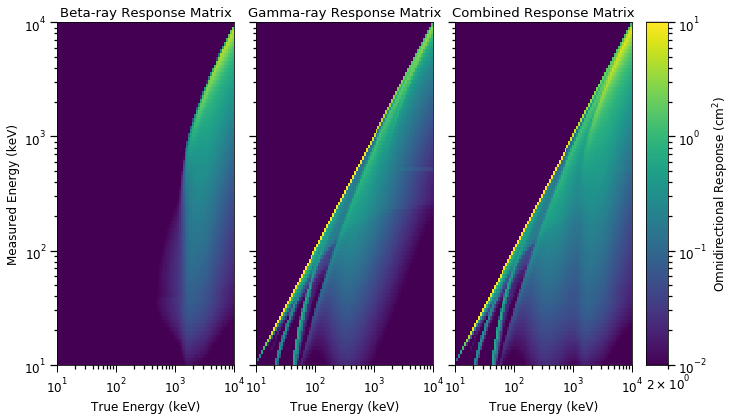

Response Matrix - Detector 2 - Eljen Plastic Detector


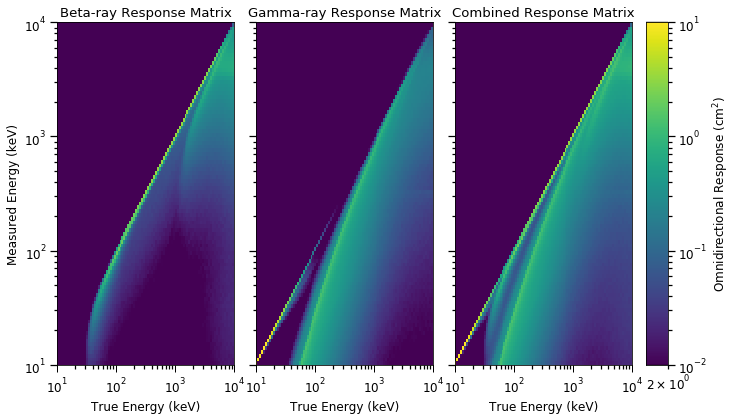

Response Matrix - Detector 3 - Canberra PD450-15-500AM


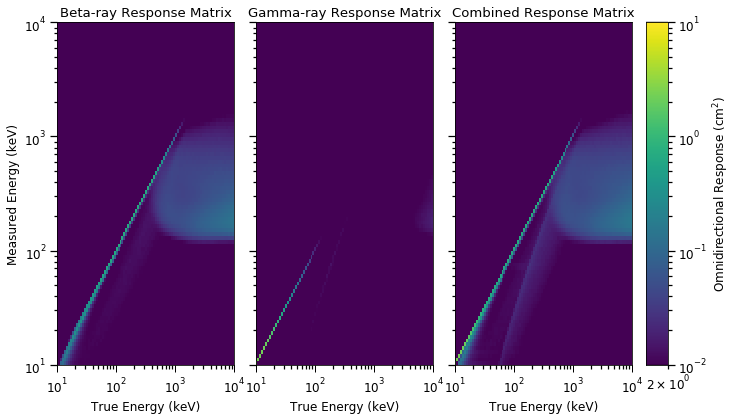

In [9]:
def plotResponseMatrix(rspns_mat_e, rspns_mat_gam, rspns_mat_comb, filename = 'Response Matrix.jpg'):
    # Plot the energy migration matrix
    fig_mig_mat = plt.figure()

    ax_mig_mat = AxesGrid(fig_mig_mat, 111,
                          nrows_ncols=(1, 3),
                          axes_pad=0.3,
                          aspect=False,
                          #label_mode = 'L',
                          cbar_mode='single',
                          cbar_location='right',
                          cbar_pad=0.2,
                          cbar_size = 0.3)

    # Color map
    cmap = palettable.matplotlib.Viridis_20.mpl_colormap
    cmap.set_bad(cmap(0.))
    cmap.set_over(cmap(1.))

    # Response Limits 
    rLimUp = np.ceil(np.abs(np.log10(np.maximum(rspns_mat_e[0].max(), rspns_mat_gam[0].max()))))
    rLimUp = 1E1
    rLimLow = rLimUp/1E3

    # Plot the response matrices
    X, Y = np.meshgrid(rspns_mat_e[1][0], rspns_mat_e[1][1])
    H0 = ax_mig_mat[0].pcolormesh(X, Y, rspns_mat_e[0].T, norm = colors.LogNorm(), cmap = cmap, rasterized = True) 

    X, Y = np.meshgrid(rspns_mat_gam[1][0], rspns_mat_gam[1][1])
    H1 = ax_mig_mat[1].pcolormesh(X, Y, rspns_mat_gam[0].T, norm = colors.LogNorm(), cmap = cmap, rasterized = True) 

    X, Y = np.meshgrid(rspns_mat_comb[1][0], rspns_mat_comb[1][1])
    H2 = ax_mig_mat[2].pcolormesh(X, Y, rspns_mat_comb[0].T, norm = colors.LogNorm(), cmap = cmap, rasterized = True) 

    # Color limits for the plot
    H0.set_clim(rLimLow, rLimUp)
    H1.set_clim(rLimLow, rLimUp)
    H2.set_clim(rLimLow, rLimUp)

    # Colorbar     
    from matplotlib.ticker import LogLocator
    ax_mig_mat.cbar_axes[0].colorbar(H2, spacing = 'uniform')
    ax_mig_mat.cbar_axes[0].set_yscale('log')
    ax_mig_mat.cbar_axes[0].axis[ax_mig_mat.cbar_axes[0].orientation].set_label('Omnidirectional Response (cm$^2$)')

    # Figure Properties
    ax_mig_mat[0].set_xscale('log')
    ax_mig_mat[0].set_yscale('log')
    ax_mig_mat[0].set_ylabel('Measured Energy (keV)')
    ax_mig_mat[0].set_xlabel('True Energy (keV)')
    ax_mig_mat[0].set_title('Beta-ray Response Matrix')

    ax_mig_mat[1].set_xscale('log')
    ax_mig_mat[1].set_yscale('log')
    ax_mig_mat[1].set_xlabel('True Energy (keV)')
    ax_mig_mat[1].set_title('Gamma-ray Response Matrix')

    ax_mig_mat[2].set_xscale('log')
    ax_mig_mat[2].set_yscale('log')
    ax_mig_mat[2].set_xlabel('True Energy (keV)')
    ax_mig_mat[2].set_title('Combined Response Matrix')

    # Fine-tune figure 
    fig_mig_mat.set_tight_layout(False)
    
    # Save the figure
    plt.savefig(filename, bbox_inches="tight")

    # Show the figure
    plt.show(fig_mig_mat)
    plt.close(fig_mig_mat)
    
print('Response Matrix - Detector 1 - ' + det1)
plotResponseMatrix(rspns_mat_det1_e, rspns_mat_det1_gam, rspns_mat_det1_comb, det1 + ' Response Matrix.jpg')
print('Response Matrix - Detector 2 - ' + det2)
plotResponseMatrix(rspns_mat_det2_e, rspns_mat_det2_gam, rspns_mat_det2_comb, det2 + ' Response Matrix.jpg')
print('Response Matrix - Detector 3 - ' + det3)
plotResponseMatrix(rspns_mat_det3_e, rspns_mat_det3_gam, rspns_mat_det3_comb, det3 + ' Response Matrix.jpg')

## STEP 2 - Import the measured spectra from each detector

In [10]:
# Load the ROOT file containing the measured spectrum
f_meas = ROOT.TFile.Open('./TestData/'+det1+'/'+isotope+'/'+f_data)

# Retrieve the measured spectrum
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
meas_vec_det1 = np.asarray(root_numpy.hist2array(f_meas.Get('Detector Measured Spectrum'), 
                                            include_overflow=False, copy=True, return_edges=True))

truth_vec_det1_e = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Electron)'),
                                               include_overflow=False, copy=True, return_edges=True))

truth_vec_det1_gam = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Gamma)'),
                                                 include_overflow=False, copy=True, return_edges=True))

# Remove elements below threshold energy
meas_vec_det1[0] = np.delete(meas_vec_det1[0], np.where(meas_vec_det1[1][0] < thld_e), axis=0)
meas_vec_det1[1] = np.delete(meas_vec_det1[1], np.where(meas_vec_det1[1][0] < thld_e), axis=1)
truth_vec_det1_e[0] = np.delete(truth_vec_det1_e[0], np.where(truth_vec_det1_e[1][0] < thld_e), axis=0)
truth_vec_det1_e[1] = np.delete(truth_vec_det1_e[1], np.where(truth_vec_det1_e[1][0] < thld_e), axis=1)
truth_vec_det1_gam[0] = np.delete(truth_vec_det1_gam[0], np.where(truth_vec_det1_gam[1][0] < thld_e), axis=0)
truth_vec_det1_gam[1] = np.delete(truth_vec_det1_gam[1], np.where(truth_vec_det1_gam[1][0] < thld_e), axis=1)

In [11]:
# Load the ROOT file containing the measured spectrum
f_meas = ROOT.TFile.Open('./TestData/'+det2+'/'+isotope+'/'+f_data)

# Retrieve the measured spectrum
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
meas_vec_det2 = np.asarray(root_numpy.hist2array(f_meas.Get('Detector Measured Spectrum'), 
                                            include_overflow=False, copy=True, return_edges=True))

truth_vec_det2_e = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Electron)'),
                                               include_overflow=False, copy=True, return_edges=True))

truth_vec_det2_gam = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Gamma)'),
                                                 include_overflow=False, copy=True, return_edges=True))

# Remove elements below threshold energy
meas_vec_det2[0] = np.delete(meas_vec_det2[0], np.where(meas_vec_det2[1][0] < thld_e), axis=0)
meas_vec_det2[1] = np.delete(meas_vec_det2[1], np.where(meas_vec_det2[1][0] < thld_e), axis=1)
truth_vec_det2_e[0] = np.delete(truth_vec_det2_e[0], np.where(truth_vec_det2_e[1][0] < thld_e), axis=0)
truth_vec_det2_e[1] = np.delete(truth_vec_det2_e[1], np.where(truth_vec_det2_e[1][0] < thld_e), axis=1)
truth_vec_det2_gam[0] = np.delete(truth_vec_det2_gam[0], np.where(truth_vec_det2_gam[1][0] < thld_e), axis=0)
truth_vec_det2_gam[1] = np.delete(truth_vec_det2_gam[1], np.where(truth_vec_det2_gam[1][0] < thld_e), axis=1)

In [12]:
# Load the ROOT file containing the measured spectrum
f_meas = ROOT.TFile.Open('./TestData/'+det3+'/'+isotope+'/'+f_data)

# Retrieve the measured spectrum
# NOTE: Index 0 contains the bin values
#       Index 1 contains the bin edges
meas_vec_det3 = np.asarray(root_numpy.hist2array(f_meas.Get('Detector Measured Spectrum'), 
                                            include_overflow=False, copy=True, return_edges=True))

truth_vec_det3_e = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Electron)'),
                                               include_overflow=False, copy=True, return_edges=True))

truth_vec_det3_gam = np.asarray(root_numpy.hist2array(f_meas.Get('Source Spectrum (Gamma)'),
                                                 include_overflow=False, copy=True, return_edges=True))

# Remove elements below threshold energy
meas_vec_det3[0] = np.delete(meas_vec_det3[0], np.where(meas_vec_det3[1][0] < thld_e), axis=0)
meas_vec_det3[1] = np.delete(meas_vec_det3[1], np.where(meas_vec_det3[1][0] < thld_e), axis=1)
truth_vec_det3_e[0] = np.delete(truth_vec_det3_e[0], np.where(truth_vec_det3_e[1][0] < thld_e), axis=0)
truth_vec_det3_e[1] = np.delete(truth_vec_det3_e[1], np.where(truth_vec_det3_e[1][0] < thld_e), axis=1)
truth_vec_det3_gam[0] = np.delete(truth_vec_det3_gam[0], np.where(truth_vec_det3_gam[1][0] < thld_e), axis=0)
truth_vec_det3_gam[1] = np.delete(truth_vec_det3_gam[1], np.where(truth_vec_det3_gam[1][0] < thld_e), axis=1)

Measured Spectrum - Detector 1 - Saint Gobain B380 LaBr3


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


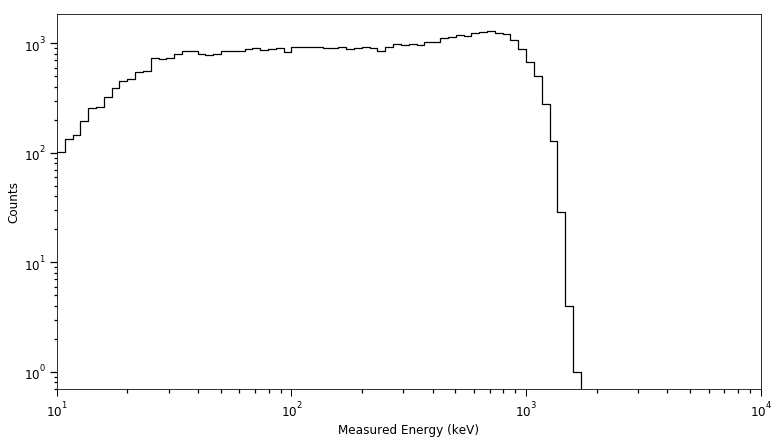

Measured Spectrum - Detector 2 - Eljen Plastic Detector


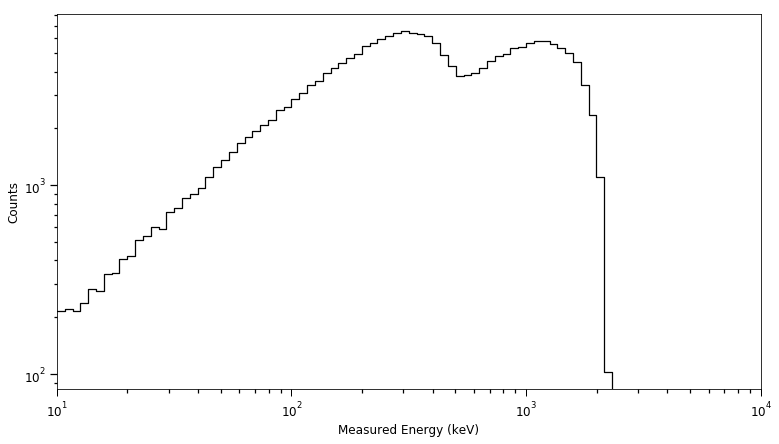

Measured Spectrum - Detector 3 - Canberra PD450-15-500AM


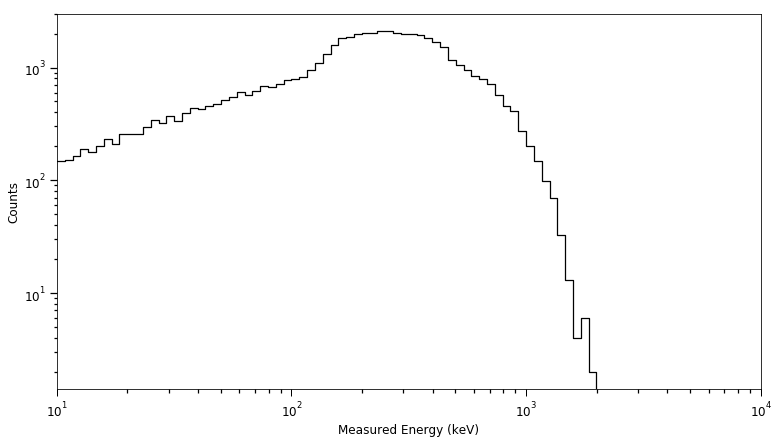

In [13]:
# Plot the measured spectrum
def plotMeasuredSpectrum(meas_vec, filename = 'Measured Spectrum.jpg'):
    # Plot the measured spectrum
    fig_meas_vec, ax_meas_vec = plt.subplots()

    # Plot the raw spectrum
    ax_meas_vec.plot(sorted(np.append(meas_vec[1][0][:-1], meas_vec[1][0][1:])),
                    np.repeat(meas_vec[0], 2),
                    lw=1.25,
                    color='black',
                    linestyle="-",
                    drawstyle='steps')

    # Figure properties
    ax_meas_vec.set_xlabel('Measured Energy (keV)')
    ax_meas_vec.set_ylabel('Counts')
    ax_meas_vec.set_xlim(min(meas_vec[1][0]),max(meas_vec[1][0]))
    ax_meas_vec.set_xscale('log')
    ax_meas_vec.set_yscale('log')

    # Fine-tune figure 
    fig_meas_vec.set_tight_layout(True)
    
    # Save the figure
    plt.savefig(filename, bbox_inches="tight")
    
    # Show the figure
    plt.show(fig_meas_vec)
    plt.close(fig_meas_vec)
    
print('Measured Spectrum - Detector 1 - ' + det1)
plotMeasuredSpectrum(meas_vec_det1, isotope + ' - ' + det1 + ' - Measured Spectrum.jpg')
print('Measured Spectrum - Detector 2 - ' + det2)
plotMeasuredSpectrum(meas_vec_det2, isotope + ' - ' + det2 + ' - Measured Spectrum.jpg')
print('Measured Spectrum - Detector 3 - ' + det3)
plotMeasuredSpectrum(meas_vec_det3, isotope + ' - ' + det3 + ' - Measured Spectrum.jpg')

## STEP 3  - Build the generative models
Generally, when a detector is exposed to a homogeneous radiation field, the relationship between the incoming particle fluence spectrum and the measured energy spectrum, $D(E)$, can be described by the following Fredholm integral equation of the first kind:

$$D\left(E\right) = \int_{0}^{\infty}R\left(E, E^{'}\right)\Phi\left(E^{'}\right)dE^{'} \ ,\ 0 \leq E \leq \infty$$

where $R\left(E, E^{'}\right)$ is a kernel describing the detector response in terms of the measured energy, $E$, and the true energy, $E^{'}$, of the incoming particle and $\Phi\left(E^{'}\right)$ is the incoming particle fluence spectrum.

Within the context of Bayesian inference, the above equation is often refered to as the generative model that describes how the measured data was generated when the detector was exposed to the radiation field. 

For this systematic testing, the following generative models are available:
- **model_det1** - this model uses **only** the response matrix and measured spectra from Detector 1 (det1)

In [156]:
def asMat(x):
    '''
    Transform an array of doubles into a Theano-type array so that it can be used in the model
    '''
    return np.asarray(x,dtype=theano.config.floatX)

with pm.Model() as model_det1:
    ''' 
    Define the upper and lower bounds of the uniform prior based on the measured data and the response matrix
    
    For an ideal radiation detector, the response matrix would a diagonal meaning that the measured spectrum would be an exact if not close approximation of the true particle spectrum incident on the detector. However, real detectors have response matrices which often have non-diagonal components due to physical interactions (e.g. compton scaterring) which result in only partial energy depositions. As a result, the measured spectrum is not an accurate representation of the true particle spectrum incident on the detector. Nevertheless, we can use the measured spectrum in combination with the response matrix to provide a good initial or "guess" spectrum for the Bayesian inference.
    '''
    
    lb_phi_e = np.zeros(rspns_mat_det1_e[1][0].size - 1)
    ub_phi_e = np.zeros(rspns_mat_det1_e[1][0].size - 1)
    lb_phi_gam = np.zeros(rspns_mat_det1_gam[1][0].size - 1)
    ub_phi_gam = np.zeros(rspns_mat_det1_gam[1][0].size - 1)
    
    # Get the upper and lower bounds from the combined response matrix
    t = Texttable()
    t.add_row(['True Energy', 'Min Phi (cm-2)', 'Max Phi (cm-2)'])
    for i in np.arange(rspns_mat_det1_comb[1][0].size - 1):
        # Find the minimum and maximum non-zero response elements for each true energy
        index_det1_min = np.argwhere(rspns_mat_det1_comb[0][i,:] == np.min(rspns_mat_det1_comb[0][i,:][np.nonzero(rspns_mat_det1_comb[0][i,:])])).flatten()[0]
        index_det1_max = np.argwhere(rspns_mat_det1_comb[0][i,:] == rspns_mat_det1_comb[0][i,:].max()).flatten()[0]
        
        # Calculate the lower and upper bounds on the prior based on the measured counts at the above
        # indeces and response elements
        min_phi = np.min([meas_vec_det1[0][index_det1_min], meas_vec_det1[0][index_det1_max]])/rspns_mat_det1_comb[0][i,index_det1_max]
        
        max_phi = np.max([meas_vec_det1[0][index_det1_min], meas_vec_det1[0][index_det1_max]])/rspns_mat_det1_comb[0][i,index_det1_min]
            
        # Update the bounds
        #lb_phi_e[i] = min_phi
        ub_phi_e[i] = max_phi
        #lb_phi_gam[i] = min_phi
        ub_phi_gam[i] = max_phi
        
        # Add it to the table for printout
        t.add_row(['{:.1f} kev'.format(rspns_mat_det1_comb[1][0][i]),
                   '{:.3e} e-\n{:.3e} gam'.format(lb_phi_e[i], lb_phi_gam[i]),
                   '{:.3e} e-\n{:.3e} gam'.format(ub_phi_e[i], ub_phi_gam[i])])
        
    #print t.draw()
    
    # Define the prior probability densities
    phi_e = pm.Uniform('phi_e', lower = lb_phi_e, upper = ub_phi_e, shape = (ub_phi_e.size))
    phi_gam = pm.Uniform('phi_gam', lower = lb_phi_gam, upper = ub_phi_gam, shape = (ub_phi_gam.size))
    
    # Define the generative models
    M_det1 = theano.tensor.dot(theano.shared(asMat(rspns_mat_det1_e[0].T)), phi_e) + \
             theano.tensor.dot(theano.shared(asMat(rspns_mat_det1_gam[0].T)), phi_gam)

    # Define the likelihood (aka. posterior probability function)
    PPF_det1 = pm.Poisson('PPF_det1', mu = M_det1, observed = theano.shared(meas_vec_det1[0], borrow = True), shape = (meas_vec_det1[0].size, 1))

In [15]:
class DiscreteUniform(object):
    R"""
    Discrete uniform distribution.
    The pmf of this distribution is
    .. math:: f(x \mid lower, upper) = \frac{1}{upper-lower+1}
    .. plot::
        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        ls = [1, -2]
        us = [6, 2]
        for l, u in zip(ls, us):
            x = np.arange(l, u+1)
            pmf = [1.0 / (u - l + 1)] * len(x)
            plt.plot(x, pmf, '-o', label='lower = {}, upper = {}'.format(l, u))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0, 0.4)
        plt.legend(loc=1)
        plt.show()
    ========  ===============================================
    Support   :math:`x \in {lower, lower + 1, \ldots, upper}`
    Mean      :math:`\dfrac{lower + upper}{2}`
    Variance  :math:`\dfrac{(upper - lower)^2}{12}`
    ========  ===============================================
    Parameters
    ----------
    lower : int
        Lower limit.
    upper : int
        Upper limit (upper > lower).
    """

    def __init__(self, lower, upper, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lower = intX(tt.floor(lower))
        self.upper = intX(tt.floor(upper))
        self.mode = tt.maximum(intX(tt.floor((upper + lower) / 2.)), self.lower)

    def _random(self, lower, upper, size=None):
        # This way seems to be the only to deal with lower and upper
        # as array-like.
        samples = stats.randint.rvs(lower, upper + 1, size=size)
        return samples

    def random(self, point=None, size=None):
        """
        Draw random values from DiscreteUniform distribution.
        Parameters
        ----------
        point : dict, optional
            Dict of variable values on which random values are to be
            conditioned (uses default point if not specified).
        size : int, optional
            Desired size of random sample (returns one sample if not
            specified).
        Returns
        -------
        array
        """
        lower, upper = draw_values([self.lower, self.upper], point=point, size=size)
        return generate_samples(self._random,
                                lower, upper,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Calculate log-probability of DiscreteUniform distribution at specified value.
        Parameters
        ----------
        value : numeric
            Value(s) for which log-probability is calculated. If the log probabilities for multiple
            values are desired the values must be provided in a numpy array or theano tensor
        Returns
        -------
        TensorVariable
        """
        upper = self.upper
        lower = self.lower
        return bound(-tt.log(upper - lower + 1),
                     lower <= value, value <= upper)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        lower = dist.lower
        upper = dist.upper
        name = r'\text{%s}' % name
        return r'${} \sim \text{{DiscreteUniform}}(\mathit{{lower}}={},~\mathit{{upper}}={})$'.format(name,
                                                get_variable_name(lower),
                                                get_variable_name(upper))

In [22]:
import numpy as np
from scipy import stats
from emcee import EnsembleSampler
try:
    import matplotlib.pyplot as plt
except:
    plt = None


def lnlike_geom(p, y):
    """
    The probability distribution of the number of failures before the first
    success, supported on the set { 0, 1, 2, 3, ... }.
    See http://en.wikipedia.org/wiki/Geometric_distribution
    """
    return (y * np.log(1. - p) + np.log(p)).sum()


# Beta(0.1, 5) prior on geometrical distribution ``p`` parameter
# - VERY informative (but i am trying to replicate ``pymc`` result).
def lnprior_geom(p):
    return stats.beta.logpdf(p, 0.1, 5.)


def lnpost_geom(p, y):
    lnpr = lnprior_geom(p)
    if np.isinf(lnpr):
        return -np.inf
    else:
        return lnlike_geom(p, y) + lnpr


def lnlike_pois(lambda_, y):
    return stats.poisson.logpmf(y, lambda_).sum()


# Uniform(0, 1000) prior on Poisson distribution ``lambda`` parameter
def lnprior_pois(lambda_):
    return stats.uniform.logpdf(lambda_, 0., 1000.)


def lnpost_pois(lambda_, y):
    lnpr = lnprior_pois(lambda_)
    if np.isinf(lnpr):
        return -np.inf
    else:
        return lnlike_pois(lambda_, y) + lnpr


if __name__ == '__main__':
    y = np.array([0, 1, 2, 3, 8])
    nwalkers = 50
    ndim = 1

    print "Check prob. functions using EnsembleSampler"
    print "Checking geometrical model..."
    sampler = EnsembleSampler(nwalkers, ndim, lnpost_geom, args=(y,))
    p0 = np.random.uniform(low=0, high=1.0, size=(nwalkers, ndim))
    
    print sampler.sample(p0, iterations=200)
    
    for p, lnprob, lnlike in sampler.sample(p0, iterations=200):
        pass
    
    sampler.reset()
    for p, lnprob, lnlike in sampler.sample(p, iterations=2000, thin=10):
        pass

    if plt:
        plt.hist(sampler.flatchain[::10, :], bins=30, normed=True)
        plt.xlabel(r'p for geometrical model')
        plt.ylabel(r'p(p | data)')
        plt.show()

Check prob. functions using EnsembleSampler
Checking geometrical model...
<generator object sample at 0x7efe212a6be0>


ValueError: too many values to unpack

In [24]:
import scipy
phi_beta = scipy.stats.randint(low=0, high=100, size=(10, 3))

TypeError: _parse_args() got an unexpected keyword argument 'size'